<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Solutions_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Solutions to Part 1.

In [1]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import metrics

from matplotlib import  pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import os
from imageio import imread
import pandas as pd
from time import time as timer

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [2]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    !tar -xvzf colab_material.tgz > /dev/null 2>&1

In [3]:
pip install dtreeviz==1.4.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
from dtreeviz.trees import dtreeviz # remember to load the package

In this course we will use several synthetic and real-world datasets to ilustrate the behavior of the models and excercise our skills.

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [5]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))
  
  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [2.2939551] ;  b = -1.88803419645774


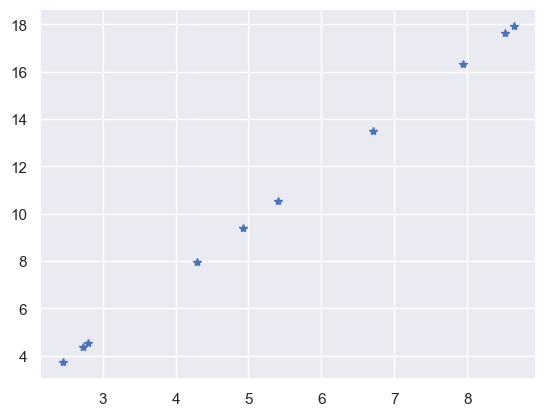

In [6]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')

true slopes: w = [6.58310878 9.99838238] ;  b = -9.798911862731035


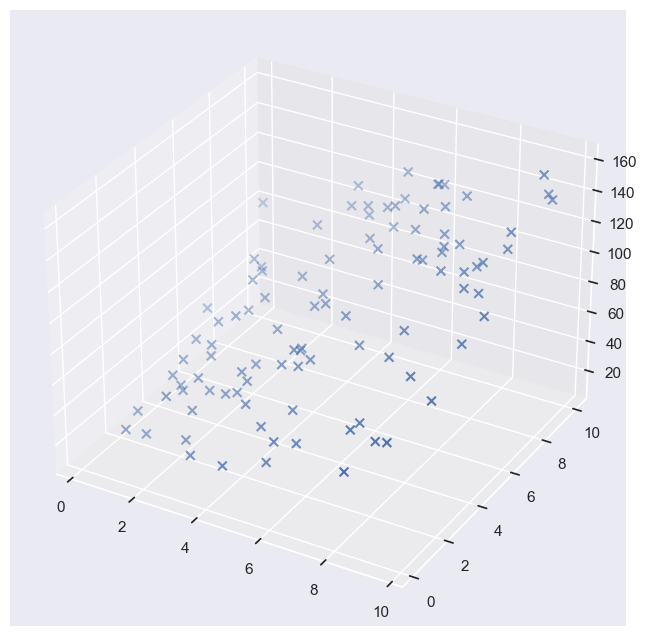

In [7]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [8]:
def house_prices_dataset(return_df=False, return_df_xy=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )
  
  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)
  
  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [9]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


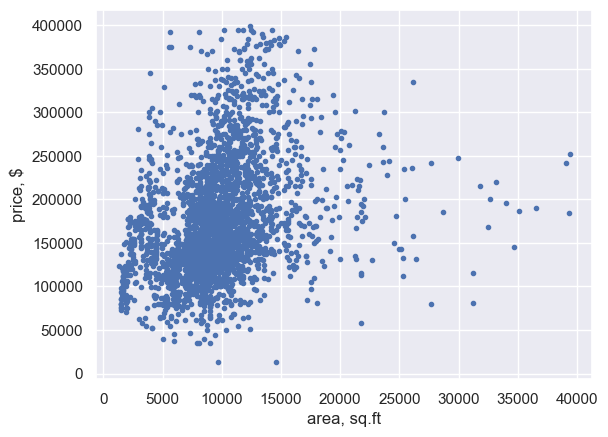

In [10]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');

## 3. Blobs

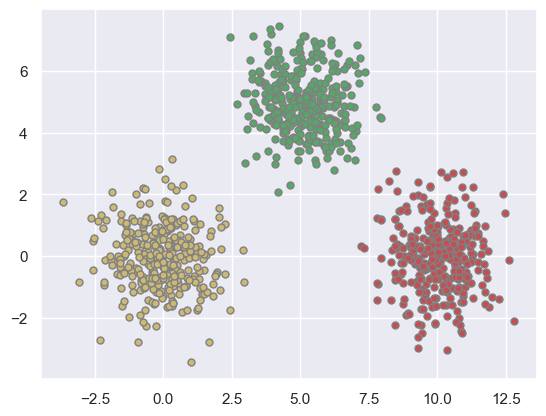

In [11]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [12]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

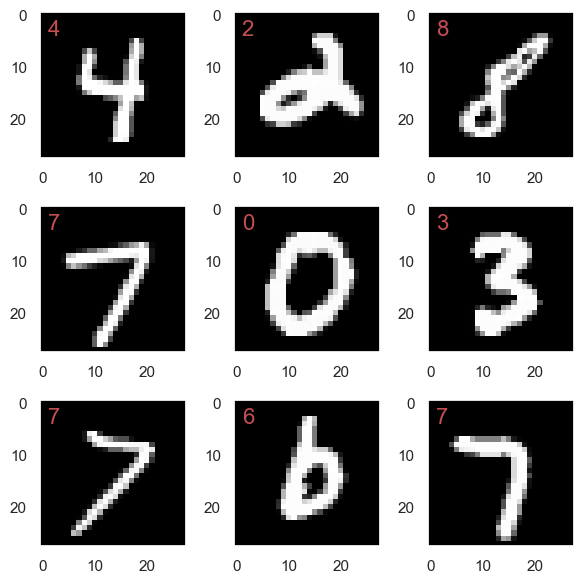

In [14]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()


## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [15]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

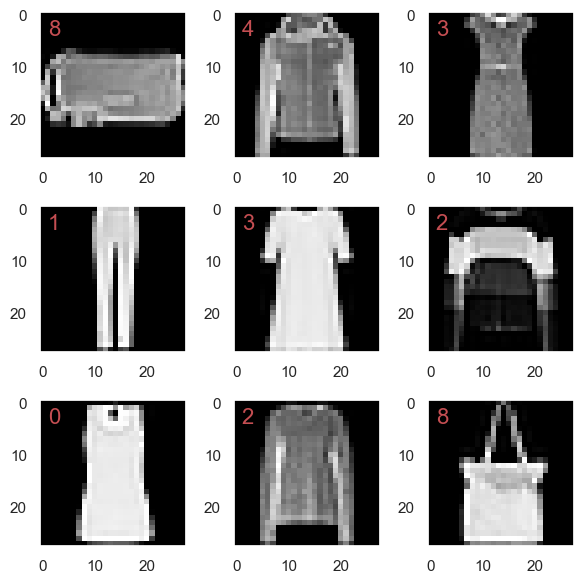

In [17]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()

In [18]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# EXERCISE 1.

train mse = 24705.814
test mse = 31634.053
train mae = 18207.926
test mae = 18728.096
train R2 = 0.8612903574361331
test R2 = 0.7566739745045103


[]

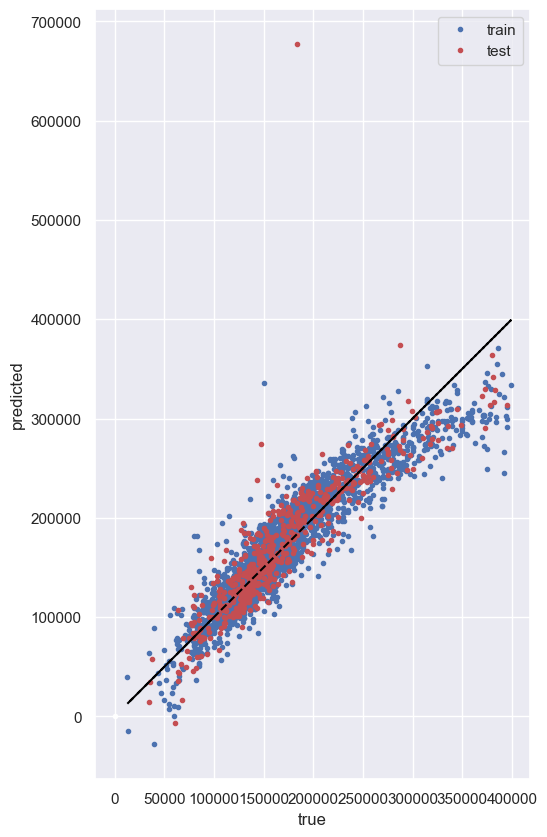

In [19]:
# Solution:
x, y = house_prices_dataset()

# 1. make train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 2. fit the model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# 3. evaluate MSE, MAD, and R2 on train and test datasets
#prediction:
y_p_train = reg.predict(x_train)
y_p_test = reg.predict(x_test)

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))
# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', reg.score(x_train, y_train))
print('test R2 =', reg.score(x_test, y_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train,y_train,'--',color='black')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

# EXERCISE 2.

In [20]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

We will reshape 2-d images to 1-d arrays for use in scikit-learn:

In [21]:
n_train = len(train_labels)
x_train = train_images.reshape((n_train, -1))
y_train = train_labels

n_test = len(test_labels)
x_test = test_images.reshape((n_test, -1))
y_test = test_labels

Now use a multinomial logistic regression classifier, and measure the accuracy:

In [22]:
#solution
# 1. Create classifier
multi_class = 'multinomial'
clf = linear_model.LogisticRegression(solver='sag', max_iter=20,
                                      multi_class=multi_class)

# 2. fit the model
t1 = timer()
clf.fit(x_train, y_train)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(x_train, y_train)))
print("test score : %.3f" % (clf.score(x_test, y_test)))


training time: 35.4s
training score : 0.874
test score : 0.843


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# EXERCISE 3 : Random forest classifier for FMNIST


In [23]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

n = len(train_labels)
x_train = train_images.reshape((n, -1))
y_train = train_labels

n_test = len(test_labels)
x_test = test_images.reshape((n_test, -1))
y_test = test_labels

In [24]:
# 1. Create classifier. As the number of features is big, use bigger tree depth 
# (max_depth parameter). in the same time to reduce variance, one should limit the
# total number of tree leafes. (max_leaf_nodes parameter)
# Try different number of estimators (n_estimators)

n_est = 20

dtc = ensemble.RandomForestClassifier(max_depth=700, n_estimators=n_est, max_leaf_nodes=500)

# 2. fit the model
t1 = timer()
dtc.fit(x_train, y_train)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. Inspect training and test accuracy
print("training score : %.3f (n_est=%d)" % (dtc.score(x_train, y_train), n_est))
print("test score : %.3f (n_est=%d)" % (dtc.score(x_test, y_test), n_est))


training time: 16.2s
training score : 0.893 (n_est=20)
test score : 0.856 (n_est=20)


## EXERCISE 4: Random forest regression


In [39]:
X, y, (df_x, df_y) = house_prices_dataset(return_df_xy=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
a = list(df_x.keys())[:-1]
print(len(a))
rfr.estimators_[10]

23


DecisionTreeRegressor(max_depth=5, max_features=1.0, random_state=1778776768)

Predict the house prices.

In [41]:
rfr = ensemble.RandomForestRegressor(max_depth=5, n_estimators=30)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8273797558823656

C:\Users\User\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


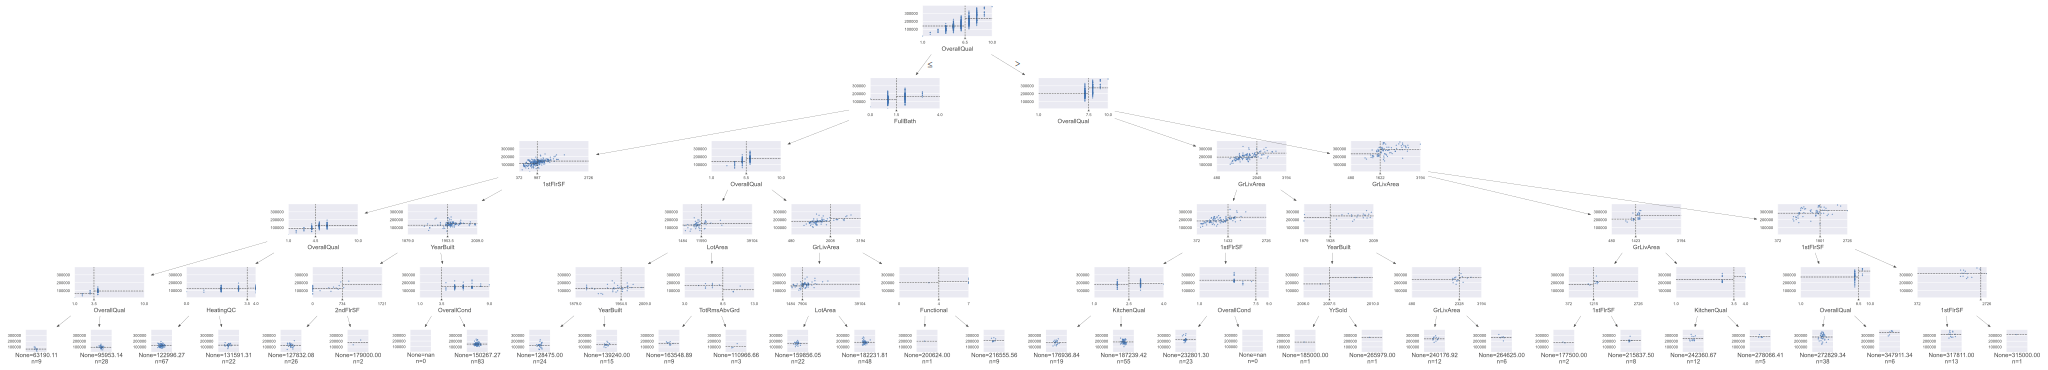

In [42]:
viz = dtreeviz(rfr.estimators_[10], x_test, y_test, feature_names=a)
display(viz)

In [43]:
rfr = ensemble.RandomForestRegressor(max_depth=30, n_estimators=70)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8702340070752798

[]

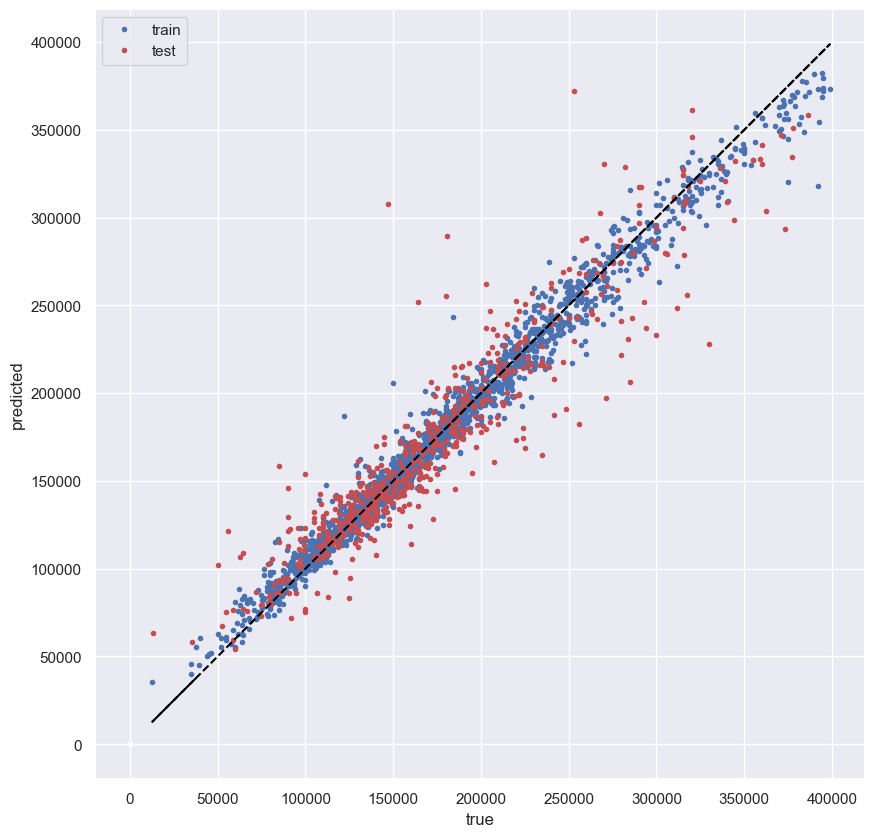

In [44]:
y_p_train = rfr.predict(x_train)
y_p_test = rfr.predict(x_test)


# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train,y_train,'--',color='black')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

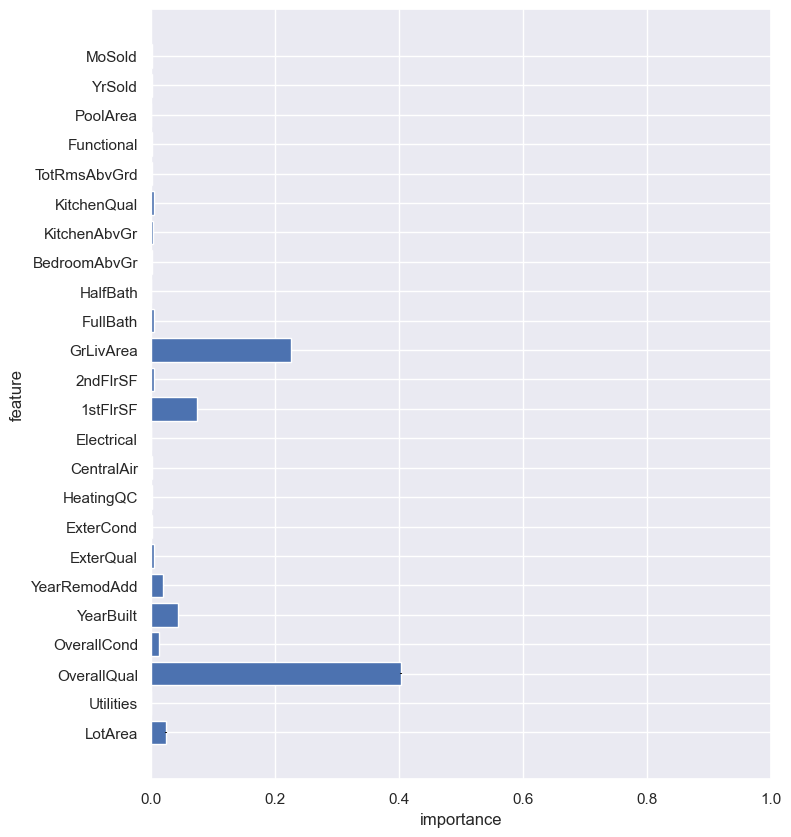

In [30]:
p_importances = permutation_importance(rfr, x_test, y_test, n_repeats=10, n_jobs=-1)

plt.figure(figsize=(8, 10))
plt.barh(list(df_x.columns),
        p_importances.importances_mean,
        yerr=p_importances.importances_std, )
plt.ylabel('feature')
plt.xlabel('importance')
plt.xlim(0, 1);